# Variational autoencoder for 1D data 

In this notebook, we will implement a variational autoencoder (VAE) for 1D data which was generated from the mixture of several Gaussian distributions. 

I follow the theory behind VAEs outlined in [Understanding Deep Learning](https://udlbook.github.io/udlbook/) by Simon J.D. Prince, chapter 17.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import MSELoss
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os
from tqdm import tqdm

%matplotlib inline

# 1D Data preparation

cpu


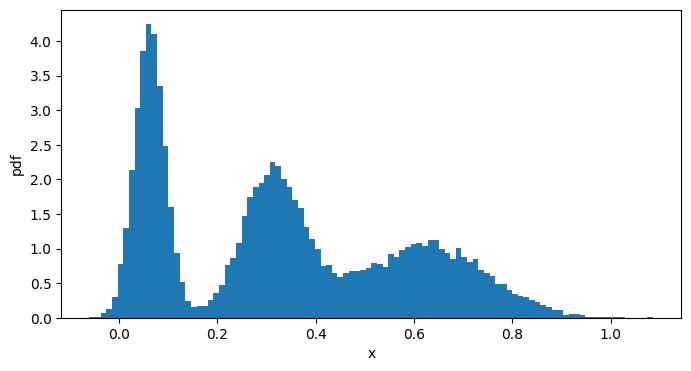

In [2]:
class MyDataset(Dataset):
    def __init__(self, means_list = [1, 5, 10], stds_list = [0.5, 1, 3], size = 10000, seed = 0):
        
        rvs_list = [stats.norm(loc=mean, scale=std) for mean, std in zip(means_list, stds_list)]

        np.random.seed(seed)
        x_train = np.concatenate([rvs.rvs(size) for rvs in rvs_list])
        
        #shuffle
        np.random.shuffle(x_train)

        #normalize x_train to the max of means + 3 stds
        norm = max(means_list) + 3 * max(stds_list)
        x_train = x_train / norm

        self.x = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
        self.x_numpy = x_train

        #self.rvs_list = rvs_list
        #self.n_rvs = len(rvs_list)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]
    
    def plot_data(self):
        fig,  ax =  plt.subplots( figsize = (8,4))
        ax.hist(self.x_numpy, bins = 100, density = True)

        #for rvs in self.rvs_list:
        #    x = np.linspace(rvs.ppf(0.001), rvs.ppf(0.999), 100)
        #    ax.plot(x, rvs.pdf(x)/self.n_rvs, lw=2, alpha=0.6)
        ax.set_xlabel('x')
        ax.set_ylabel('pdf')
        plt.show()


BATCH_SIZE = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_dataset = MyDataset(means_list = [1, 5, 10],
                          stds_list = [0.5, 1, 2],
                            seed = 42)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
train_dataset.plot_data()

In [3]:
# sanity check of batch size and shape
one_batch = next(iter(train_loader))
one_batch.shape

torch.Size([25, 1])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self,  latent_dim, input_dim=1, hidden_dim = 256):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

        self.input_dim = input_dim

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_function(recon_x, x, mu, logvar, KL_weight = 1.0):
    # Reconstruction loss
    MSE = F.mse_loss(recon_x, x.view(-1, 1), reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + KLD*KL_weight


In [5]:
def train(model, optimizer, train_loader, num_epochs, KL_weight = 1.0):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, KL_weight = KL_weight)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print('Epoch {}: Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


In [6]:
latent_dim = 10
lr = 1e-3
kl_weight = 1

vae = VAE(latent_dim = latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)


In [7]:

num_epochs = 10
train(vae, optimizer, train_loader, num_epochs, KL_weight = kl_weight)


Epoch 0: Average loss: 0.0661
Epoch 1: Average loss: 0.0627
Epoch 2: Average loss: 0.0617
Epoch 3: Average loss: 0.0613
Epoch 4: Average loss: 0.0609
Epoch 5: Average loss: 0.0606
Epoch 6: Average loss: 0.0603
Epoch 7: Average loss: 0.0601
Epoch 8: Average loss: 0.0600
Epoch 9: Average loss: 0.0599


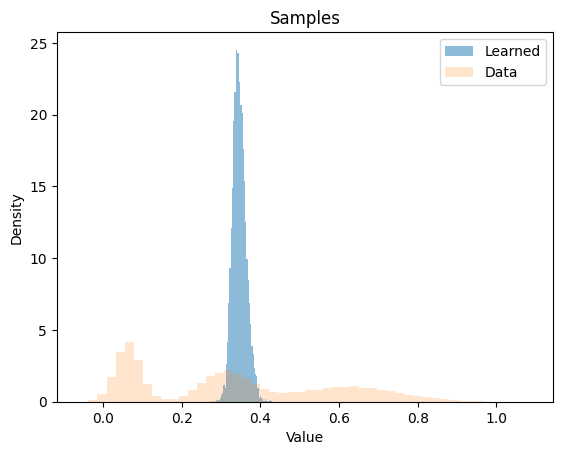

In [8]:
def generate_samples(vae, num_samples):
    # Sample from standard normal distribution
    z = torch.randn(num_samples, vae.fc21.out_features)

    # Generate samples by decoding the latent vector
    samples = vae.decode(z)

    return samples

def visualize_samples(samples, data=None, bins = 50):
    # Convert tensor to numpy array for visualization
    samples = samples.detach().numpy()

    # Create a histogram
    plt.hist(samples, bins=bins, density=True, alpha = 0.5)
    plt.xlabel('Value')
    plt.ylabel('Density')

    if data is not None:
        # Plot the data distribution
        data = data.numpy()
        plt.hist(data, bins=bins, density=True, alpha=0.2)
        plt.legend(['Learned', 'Data'])
    plt.title('Samples')
    plt.show()

# Generate 1000 samples
samples = generate_samples(vae, 10000)

# Visualize the samples
visualize_samples(samples, train_dataset.x)